In [14]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace

In [15]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './dataset/food-11/'
}
args = argparse.Namespace(**args)

In [16]:
#Model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        #torch.nn.MaxPool2d(kernel_size, stride, padding)
        #input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
#         out = out.view(out.size()[0], -1)
        out = out.contiguous().view(out.size()[0], -1)
        return self.fc(out)

In [17]:
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [18]:
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # 這個 FoodDataset 继承了 pytorch 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定义一个 pytorch dataset 时一定要 implement 的两个 methods
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 这个 method 并不是 pytorch dataset 必要，只是方便未来我们想要指定「取哪几张图片」出来当作一个 batch 来 visualize
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# 给予 data 的路径，回传每一张图片的「路径」和「class」
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

# 这边在 initialize dataset 时只丢「路径」和「class」，之后要从 dataset 取资料时
# dataset 的 __getitem__ method 才会动态的去 load 每个路径对应的图片
train_set = FoodDataset(train_paths, train_labels, mode='eval')

### Saliency map

我们把一张图片丢进 model，forward 后与 label 计算出 loss。
因此与 loss 相关的有:
- image
- model parameter
- label

通常的情况下，我们想要改变 model parameter 来 fit image 和 label。因此 loss 在计算 backward 时我们只在乎 **loss 对 model parameter** 的偏微分值。但数学上 image 本身也是 continuous tensor，我们可以计算  **loss 对 image** 的偏微分值。这个偏微分值代表「在 model parameter 和 label 都固定下，稍微改变 image 的某个 pixel value 会对 loss 产生什麽变化」。人们习惯把这个变化的剧烈程度解读成该 pixel 的重要性 (每个 pixel 都有自己的偏微分值)。因此把同一张图中，loss 对每个 pixel 的偏微分值画出来，就可以看出该图中哪些位置是 model 在判断时的重要依据。

实作上非常简单，过去我们都是 forward 后算出 loss，然后进行 backward。而这个 backward，pytorch 预设是计算 **loss 对 model parameter** 的偏微分值，因此我们只需要用一行 code 额外告知 pytorch，**image** 也是要算偏微分的对象之一。

In [19]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # 最关键的一行 code
  # 因为我们要计算 loss 对 input image 的微分，原本 input x 只是一个 tensor，预设不需要 gradient
  # 这边我们明确的告知 pytorch 这个 input x 需要gradient，这样我们执行 backward 后 x.grad 才会有微分的值
  x.requires_grad_()
  
  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  saliencies = x.grad.abs().detach().cpu()
  # saliencies: (batches, channels, height, weight)
  # 因为接下来我们要对每张图片画 saliency map，每张图片的 gradient scale 很可能有巨大落差
  # 可能第一张图片的 gradient 在 100 ~ 1000，但第二张图片的 gradient 在 0.001 ~ 0.0001
  # 如果我们用同样的色阶去画每一张 saliency 的话，第一张可能就全部都很亮，第二张就全部都很暗，
  # 如此就看不到有意义的结果，我们想看的是「单一张 saliency 内部的大小关係」，
  # 所以这边我们要对每张 saliency 各自做 normalize。手法有很多种，这边只採用最简单的
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

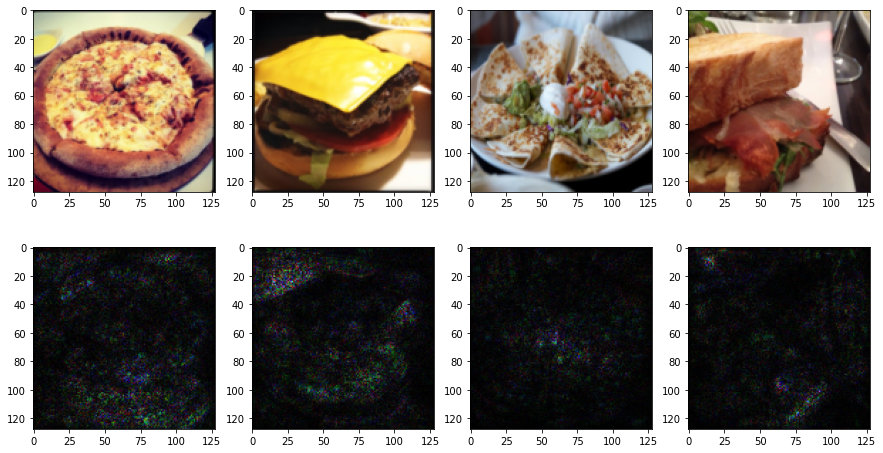

In [20]:
# 指定想要一起 visualize 的图片 indices
# img_indices = [83, 4218, 4707, 8598]
img_indices = [1,23,55,76]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# 使用 matplotlib 画出来
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
    # 小知识：permute 是什麽，为什麽这边要用?
    # 在 pytorch 的世界，image tensor 各 dimension 的意义通常为 (channels, height, width)
    # 但在 matplolib 的世界，想要把一个 tensor 画出来，形状必须为 (height, width, channels)
    # 因此 permute 是一个 pytorch 很方便的工具来做 dimension 间的转换
    # 这边 img.permute(1, 2, 0)，代表转换后的 tensor，其
    # - 第 0 个 dimension 为原本 img 的第 1 个 dimension，也就是 height
    # - 第 1 个 dimension 为原本 img 的第 2 个 dimension，也就是 width
    # - 第 2 个 dimension 为原本 img 的第 0 个 dimension，也就是 channels

plt.show()
# 从第二张图片的 saliency，我们可以发现 model 有认出蛋黄的位置
# 从第三、四张图片的 saliency，虽然不知道 model 细部用食物的哪个位置判断，但可以发现 model 找出了食物的大致轮廓

## Filter explaination

这裡我们想要知道某一个 filter 到底认出了什麽。我们会做以下两件事情：
- Filter activation: 挑几张图片出来，看看图片中哪些位置会 activate 该 filter
- Filter visualization: 怎样的 image 可以最大程度的 activate 该 filter

实作上比较困难的地方是，通常我们是直接把 image 丢进 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我们要怎麽得到中间某层 CNN 的 output? 当然我们可以直接修改 model definition，让 forward 不只 return loss，也 return activation map。但这样的写法太不漂亮了，更改了 forward 的 output 可能会让其他部分的 code 要跟著改动。因此 pytorch 提供了方便的 solution: **hook**，以下我们会再介绍。

In [21]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
  # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # 這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
  # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
  # 也有某層 cnn 的 activation map
  # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
  # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了

  # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
  model(x.cuda())
  # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
  
  # 根據 function argument 指定的 filterid 把特定 filter 的 activation map 取出來
  # 因為目前這個 activation map 我們只是要把他畫出來，所以可以直接 detach from graph 並存成 cpu tensor
  
  # Filter visualization: 接著我們要找出可以最大程度 activate 該 filter 的圖片
  x = x.cuda()
  # 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
  x.requires_grad_()
  # 我們要對 input image 算偏微分
  optimizer = Adam([x], lr=lr)
  # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)
    
    objective = -layer_activations[:, filterid, :, :].sum()
    # 與上一個作業不同的是，我們並不想知道 image 的微量變化會怎樣影響 final loss
    # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
    # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization
    
    objective.backward()
    # 計算 filter activation 對 input image 的偏微分
    optimizer.step()
    # 修改 input image 來最大化 filter activation
  filter_visualization = x.detach().cpu().squeeze()[0]
  # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor

  hook_handle.remove()
  # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
  # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
  # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。

  return filter_activations, filter_visualization

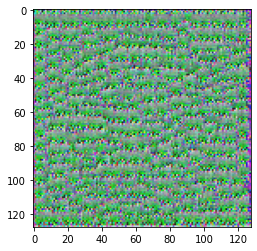

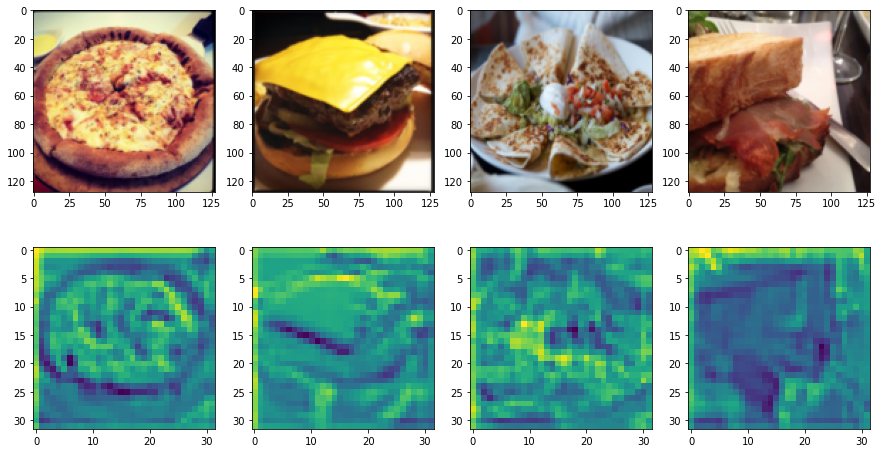

In [36]:
# img_indices = [83, 4218, 4707, 8598]
img_indices = [1,23,55,76]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=9, filterid=0, iteration=500, lr=0.1)

# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
# 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

## Lime

Lime 的部分因为有现成的套件可以使用，因此下方直接 demo 如何使用该套件。其实非常的简单，只需要 implement 两个 function 即可。

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  
100% |########################################################################|
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  
100% |########################################################################|
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  
100% |########################################################################|
/usr/local/lib/python3

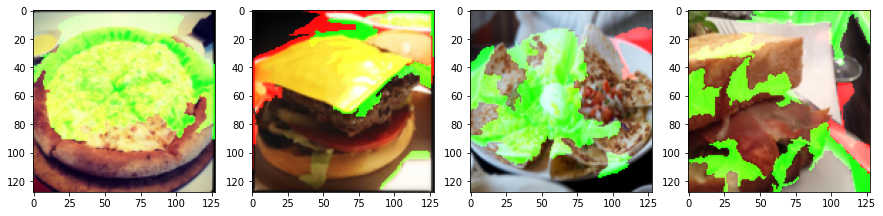

In [24]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊                                                                                                                                      
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
# img_indices = [83, 4218, 4707, 8598]
img_indices = [1,23,55,76]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.01
#                                 min_weight=1    
                            )
    # 把 explainer 解釋的結果轉成圖片
    
    axs[idx].imshow(lime_img)

plt.show()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。